In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
from matplotlib import pyplot as plt
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from conf import settings
from utils import get_network, get_test_dataloader
from models.resnet import resnet18

In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [3]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.decomposition import PCA
import numpy as np

## Set up data

In [5]:
baseline_missed = set(np.loadtxt('../baseline_wrong.txt'))
approach3_missed = set(np.loadtxt('../approach3_wrong.txt'))
print('baseline missed: {} | approach 3 missed: {}'.format(len(baseline_missed), len(approach3_missed)))
approach3_desired = baseline_missed - approach3_missed

baseline missed: 2466 | approach 3 missed: 2305


In [6]:
id2label = {}
with open('/nethome/bdevnani3/raid/pytorch-cifar100/id2label.txt', 'r') as handle:
    for idx, line in enumerate(handle):
        if idx % 2 == 0:
            element, label = line.strip().split(': ')
            id2label[int(element)] = label
len(id2label)

100

In [7]:
cifar100_test_loader = get_test_dataloader(
    settings.CIFAR100_TRAIN_MEAN,
    settings.CIFAR100_TRAIN_STD,
    #settings.CIFAR100_PATH,
    num_workers=6,
    batch_size=1,
    shuffle=False
    )

Files already downloaded and verified


## Instantiate model

In [8]:
from utils import get_network, get_training_dataloader, get_test_dataloader, WarmUpLR, \
    most_recent_folder, most_recent_weights, last_epoch, best_acc_weights, read_yaml, \
    save_yaml, name_model

# Getting configs
model_d = "/srv/share4/gstoica3/checkpoints/resnet18/3_unmasked_cls_proj/CSAM_Approach3_unmasked_cls_proj_BN_PosEmb0_AfterConv(3, 1, 3)_Temp1_StochStrideFalse_Stride1_ResidualFalse_Seed2019_k-1_Poolingsigmoid_0/Tuesday_08_March_2022_21h_16m_28s"
variant_config = read_yaml(f"{model_d}/convattn.yaml")
# variant_config["forget_gate_nonlinearity"] = "softmax"
variant_config["similarity_metric"] = "cosine_similarity"
print(variant_config)

{'apply_stochastic_stride': False, 'approach_name': '3_unmasked_cls_proj', 'forget_gate_nonlinearity': 'sigmoid', 'injection_info': [[3, 1, 3]], 'padding': 'same', 'pos_emb_dim': 0, 'random_k': -1, 'seed': 2019, 'softmax_temp': 1, 'stride': 1, 'suffix': '0', 'use_residual_connection': False, 'similarity_metric': 'cosine_similarity'}


In [9]:
from models.csam import ConvAttnWrapper

In [10]:
net = resnet18()

model = ConvAttnWrapper(backbone=net, variant_kwargs=variant_config).to('cuda:0')

{'apply_stochastic_stride': False, 'approach_name': '3_unmasked_cls_proj', 'forget_gate_nonlinearity': 'sigmoid', 'injection_info': [[3, 1, 3]], 'padding': 'same', 'pos_emb_dim': 0, 'random_k': -1, 'seed': 2019, 'softmax_temp': 1, 'stride': 1, 'suffix': '0', 'use_residual_connection': False, 'similarity_metric': 'cosine_similarity'}


../models/csam.py:251: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  self.local_indices[conv_idx] = input_mask[conv_idx].reshape(-1).nonzero().sort()[0].reshape(-1)


In [11]:
# Choose last best path
import glob
all_best = [best for best in glob.glob(f'{model_d}/*-best.pth')]
all_best.sort()
path = all_best[-1]

In [12]:
weights = torch.load(path)
net_params = {i[0]:i[1] for i in model.named_parameters()}

In [13]:
model.load_state_dict(weights)

<All keys matched successfully>

In [14]:
model.eval()

ConvAttnWrapper(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2_x): Sequential(
      (0): BasicBlock(
        (residual_function): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (residual_function): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1

In [15]:
desired_images = []
desired_labels = []
wrong_images = []
wrong_labels = []
desired_flag = False
wrong_flag = False
desired_data = 64
for n_iter, (image, label) in tqdm(enumerate(cifar100_test_loader)):
    image = image.cuda()
    if n_iter in approach3_desired and not desired_flag:
        desired_images.append(image)
        desired_labels.append(label)
    if n_iter in approach3_missed and not wrong_flag:
        wrong_images.append(image)
        wrong_labels.append(label)
    if len(desired_images) >= desired_data:
        desired_flag = True
    if len(wrong_images) >= desired_data:
        wrong_flag = True
    if desired_flag and wrong_flag: break

682it [00:00, 1264.77it/s]


In [16]:
desired_images = torch.cat(desired_images)
desired_labels = torch.cat(desired_labels)
wrong_images = torch.cat(wrong_images)
wrong_labels = torch.cat(wrong_labels)

In [17]:
predictions = model(wrong_images)

/nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
predictions = predictions.argmax(-1).detach().cpu().numpy()

In [19]:
out = wrong_images
inject_layer, inject_number, filter_size = model.variant_kwargs['injection_info'][0]
for layer in tqdm(model.network_structure[:inject_layer]):
    out = layer(out)

100%|██████████| 3/3 [00:00<00:00, 1107.55it/s]


In [20]:
out.shape

torch.Size([64, 128, 16, 16])

In [21]:
import math 
import torch.nn as nn
import sklearn

csam = model.network_structure[inject_layer]
# output = csam.approach3_v2(out)



In [22]:
batch = csam.input_padder(out)
batch = batch.permute(0, 2, 3, 1)
output = csam.approach3_v2_cls_proj(batch)
output.shape

torch.Size([64, 16, 16, 128])

In [23]:
valid_elements = (1 - csam.padding_mask).flatten(2, 4)
X = csam.maybe_add_positional_encodings(batch)                                                                  # [B,H,W,E]
batch_size, H, W, _ = X.shape
X = X.view(-1, H * W, X.shape[-1])                                                                              # [B,HW,E]
values = csam.global_transform(X)                                                                               # [B,HW,C]

X_normed = F.normalize(X, dim=-1)                                                                               # [B,HW,C]
cls_normed = F.normalize(csam.cls, dim=-1)
if csam.approach_args["similarity_metric"] == 'cosine_similarity':
    scores = torch.matmul(X_normed, cls_normed.transpose(1, 0)).transpose(2, 1)                                 # [B,HW,C] x ([1,HW] -> [HW,1]) -> [B,HW,1] -> [B,1,HW]
elif csam.approach_args["similarity_metric"] == 'dot_product':
    scores = torch.matmul(X, csam.cls.transpose(1, 0)).transpose(2, 1)                                          # [B,HW,C] x ([1,HW] -> [HW,1]) -> [B,HW,1] -> [B,1,HW]
attn = csam.masked_softmax(                                                                                     # [B,1,HW]
    scores, 
    mask=valid_elements,                                                                                        # Mask out padding indices [1, 1, HW]
    dim=-1, epsilon=1e-5 
)                                                                                                               # [B,1,HW]

filter_vec = torch.bmm(attn, values)                                                                            # [B,1,C]
filter_vals = (filter_vec * X).sum(-1, keepdim=True)                                                            # [B,1,C] x [B,HW,C] -> [B,HW,1]
projection_matrices = csam.conv_proj(filter_vec.squeeze(1)).reshape(-1, csam.spatial_C, csam.spatial_C)         # f([B,1,C] -> [B,C]) -> [B,CC] -> [B,C,C]
X_projected = torch.bmm(X, projection_matrices)                                                                 # [B,HW,C] x [B,C,C]
local_mask = csam.local_mask.flatten(1).transpose(1, 0)
filters = F.sigmoid(filter_vals)
weighted_X = filters * X                                                           # [B,HW,C] x [B,HW,1] -> [B,HW,C]
output = torch.matmul(weighted_X.transpose(2, 1), local_mask).transpose(2, 1)
output = output.reshape(
    batch_size, csam.convs_height, csam.convs_width, csam.spatial_C
)

print(output.shape)
print(filters.shape)

torch.Size([64, 16, 16, 128])
torch.Size([64, 324, 1])


In [24]:
filters.shape
filters = filters.squeeze(-1).reshape(64, 18,18)
filters = filters[:, 1:17, 1:17]
filters.shape

torch.Size([64, 16, 16])

In [25]:
output.shape

torch.Size([64, 16, 16, 128])

# Visualization Script

In [41]:
idx = 10

In [42]:
batch_pca = PCA(n_components=3)
filter_pca = PCA(n_components=1)

batch_pca.fit(out.permute(0,2,3,1)[idx].reshape(256, 128).detach().cpu().numpy())
filter_pca.fit(filters[idx].reshape(256, 1).detach().cpu().numpy())
batch_pca.fit(output[idx].reshape(256, 128).detach().cpu().numpy())
print('Batch Explained Variance: {}'.format(batch_pca.explained_variance_ratio_))
print('Filter Explained Variance: {}'.format(filter_pca.explained_variance_ratio_))
# print('CSAM Explained Variance: {}'.format(csam_pca.explained_variance_ratio_))

Batch Explained Variance: [0.19220711 0.13971709 0.12156197]
Filter Explained Variance: [1.]


In [43]:
batch_reduced = batch_pca.transform(out.permute(0,2,3,1)[idx].reshape(256, 128).detach().cpu().numpy()).reshape(16, 16, 3)
filter_reduced = filter_pca.transform(filters[idx].reshape(256, 1).detach().cpu().numpy()).reshape(16, 16, 1)
csam_reduced = batch_pca.transform(output[idx].reshape(256, 128).detach().cpu().numpy()).reshape(16, 16, 3)


# Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shark
dolphin


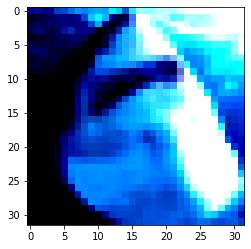

In [44]:
label = id2label[wrong_labels[idx].numpy().tolist()]
print(label)
print(id2label[predictions[idx]])
image = wrong_images[idx].permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(image)

# Visualization of CSAM Input from Vision Backbone

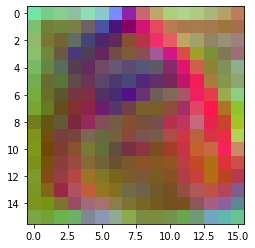

In [45]:
batch_norm = (batch_reduced - np.min(batch_reduced)) / (np.max(batch_reduced) - np.min(batch_reduced))
plt.imshow(batch_norm) 

# Visualization of CSAM Filter 

<AxesSubplot:>

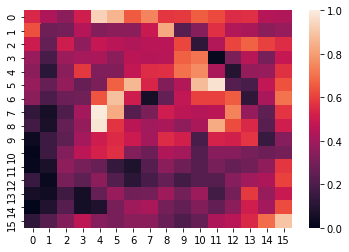

In [46]:
filter_norm = (filter_reduced - np.min(filter_reduced)) / (np.max(filter_reduced) - np.min(filter_reduced))
# plt.imshow(filter_norm)
sns.heatmap(filter_norm.squeeze(-1))

# Visualization of CSAM Output

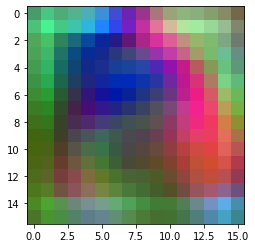

In [47]:
csam_norm = (csam_reduced - np.min(csam_reduced)) / (np.max(csam_reduced) - np.min(csam_reduced))
plt.imshow(csam_norm)

# Combined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


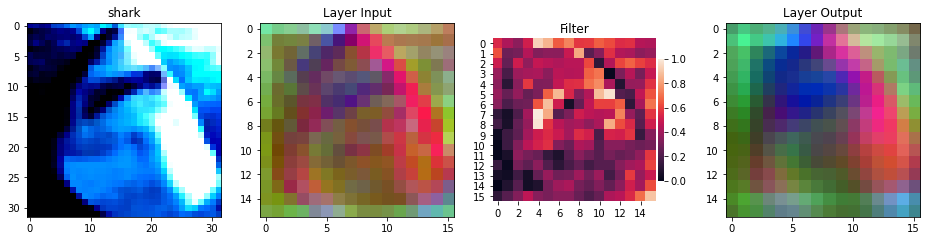

In [48]:
f, axarr = plt.subplots(1,4, figsize=(16,9))
axarr[0].imshow(image)
axarr[0].title.set_text(f'{label}')
axarr[1].imshow(batch_norm)
axarr[1].title.set_text('Layer Input')
axarr[2].imshow(filter_norm)
axarr[2].title.set_text('Filter')
sns.heatmap(filter_norm.squeeze(-1), ax=axarr[2],
           cbar_kws=dict(use_gridspec=True,pad=0.01,shrink=0.25)
           )
axarr[3].title.set_text('Layer Output')
axarr[3].imshow(csam_norm)
f.show()

## Filter deviation from uniform

In [49]:
import sklearn
devs = []
for i in range(20):
    np.random.seed(seed=i)
    uniform_dist = np.random.uniform(size = filter_norm.shape)
    dev = sklearn.metrics.mutual_info_score(filter_norm.flatten(), uniform_dist.flatten())
    devs.append(dev)
print(np.mean(devs), np.std(devs) )

5.545177444479562 0.0


/nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received cont

<AxesSubplot:>

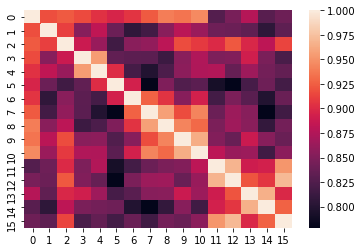

In [50]:
sim = sklearn.metrics.pairwise.cosine_similarity(filter_norm.squeeze(-1))
sns.heatmap(sim)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'Filter Row Similarity'}>

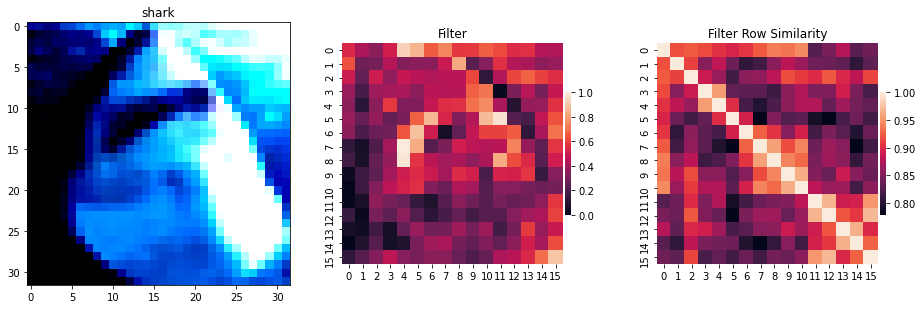

In [51]:
sim = sklearn.metrics.pairwise.cosine_similarity(filter_norm.squeeze(-1))
f, axarr = plt.subplots(1,3, figsize=(16,9))
axarr[0].imshow(image)
axarr[0].title.set_text(f'{label}')
axarr[1].imshow(filter_norm)
axarr[1].title.set_text(f'Filter')
sns.heatmap(filter_norm.squeeze(-1), ax=axarr[1],
           cbar_kws=dict(use_gridspec=True,pad=0.01,shrink=0.25)
           )
axarr[2].imshow(filter_norm)
axarr[2].title.set_text(f'Filter Row Similarity')
sns.heatmap(sim, ax=axarr[2],
           cbar_kws=dict(use_gridspec=True,pad=0.01,shrink=0.25)
           )